In [1]:
import importlib
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import swifter  # noqa: F401

from stk_search import SearchSpace
from stk_search.geom3d import train_models
from stk_search.ObjectiveFunctions.ObjectiveFunction import LookUpTable
from stk_search.Representation import (
    Representation_from_fragment,
)
from stk_search.Search_algorithm import (
    BayesianOptimisation,
    Ea_surrogate,
    Search_algorithm,
)
from stk_search.utils import database_utils


In [2]:
# run a search experiment with the new target
df_total_path_bench = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/data_benchmark/30K_benchmark_150524.csv"
df_precursor_path = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/precursor/df_properties.pkl"#"/media/mohammed/Work/STK_search/Example_notebooks/data_example/data_benchmark/precursor_with_prop.pkl"
df_precursor_Mordred_path = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/precursor/df_mordred_24072024.pkl" #s "/media/mohammed/Work/STK_search/Example_notebooks/data_example/data_benchmark/df_PCA_mordred_descriptor_290224.pkl"
SearchSpace_loc = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/data_benchmark/SearchSpace_6_frag_full.pkl"
df_precursor_path = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/data_benchmark/precursor_with_prop.pkl"
df_precursor_Mordred_path = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/data_benchmark/df_PCA_mordred_descriptor_290224.pkl"

In [3]:
# load and check the search space
SearchSpace = pd.read_pickle(SearchSpace_loc)

print(" Search space condition list:", SearchSpace.conditions_list)
print("shape of df_precursors:", SearchSpace.df_precursors.shape)
print("search space syntax:", SearchSpace.syntax)


 Search space condition list: [[], [], [], [], [], []]
shape of df_precursors: (246, 45)
search space syntax: [0, 1, 2, 3, 4, 5]


In [4]:
# load and check the dataframe to search over and the df_precursors
df_Benchmark, df_precursors = database_utils.load_data_from_file(
    df_total_path_bench, df_precursor_path, add_feature_frag=True
)
df_precursor_Mordred = pd.read_pickle(df_precursor_Mordred_path)
print("shape of df_Benchmark:", df_Benchmark.shape)
print("shape of df_precursors:", df_precursors.shape)
print("shape of df_precursor_Mordred:", df_precursor_Mordred.shape)
print(
    df_Benchmark[df_Benchmark["target"] > 0].shape[0] / df_Benchmark.shape[0]
)

shape of df_Benchmark: (30000, 207)
shape of df_precursors: (306, 40)
shape of df_precursor_Mordred: (312, 101)
0.0111


In [5]:
SearchSpace.df_precursors = df_precursors
num_of_elem_in_SP = SearchSpace.check_df_for_element_from_sp(
    df_Benchmark
).shape
print(
    "number of elements in the benchmark in the search space:",
    num_of_elem_in_SP,
)

number of elements in the benchmark in the search space: (30000, 207)


In [6]:
# set the benchmark parameters
exp_name = "Benchmark_30k_dataset"
num_elem_initialisation = 50
num_iteration = 1000
target = "target"
aim = "maximise"
case_name_list = [
    "evolution_algorithm",
    "random",
    "BO_precursor",
    "ea_surrogate",
    "BO_learned",
    "BO_Mord",
]
config_dir = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/representation_learning/splitrand-nummol20000"


In [7]:
# initialise search algorithm

which_acquisition = "EI"
lim_counter = 10
BO_learned = BayesianOptimisation.BayesianOptimisation(
    which_acquisition=which_acquisition, lim_counter=lim_counter
)
EA = Search_algorithm.evolution_algorithm()
SUEA = Ea_surrogate.Ea_surrogate()
BO_Mord = BayesianOptimisation.BayesianOptimisation(
    which_acquisition=which_acquisition, lim_counter=lim_counter
)
BO_prop = BayesianOptimisation.BayesianOptimisation(
    which_acquisition=which_acquisition, lim_counter=lim_counter
)


In [8]:
# load the Representation and the model

config, min_val_loss = train_models.get_best_embedding_model(config_dir)
SUEA = Ea_surrogate.Ea_surrogate()
SUEA.config_dir = config_dir
SUEA.load_representation_model()
BO_learned.config_dir = config_dir
BO_learned.load_representation_model()

frag_properties = df_precursor_Mordred.select_dtypes(
    include=[np.number]
).columns
BO_Mord.Representation = (
    Representation_from_fragment.RepresentationFromFragment(
        df_precursor_Mordred, frag_properties
    )
)
frag_properties = []
frag_properties = df_precursors.columns[1:7]
frag_properties = frag_properties.append(df_precursors.columns[17:23])
BO_prop.Representation = (
    Representation_from_fragment.RepresentationFromFragment(
        df_precursors, frag_properties
    )
)

Model loaded:  SchNet
Model loaded:  SchNet


In [9]:
df_precursors[df_precursors["InChIKey"]=="MATVSQOKVLAMKO-UHFFFAOYSA-N"]

InChIKey  Atom_num  HOMO (eV)  LUMO (eV)  \
115  MATVSQOKVLAMKO-UHFFFAOYSA-N        22   -11.7346    -9.7273   

     HOMO_LUMO_GAP (eV)  IP (eV)  EA (eV)  total energy (eV) vipea  \
115            2.007232   7.5979   4.0388             -1425.626142   

        First excited state Energy (eV)  \
115  [3.404, 3.838, 4.01, 4.167, 4.243]   

                            First excited osc  ...       pca1      pca2  \
115  [0.0002, 0.0517, 0.0725, 0.2704, 0.1228]  ... -24.206605 -3.198509   

         pca3       pca4      pca5      pca6      pca7      pca8      pca9  \
115  9.907594 -11.389404 -6.382819 -4.714063  0.986315  4.048869  0.041876   

     check  
115      1  

[1 rows x 40 columns]

In [20]:
# test representation

molecule_id = np.random.randint(0, df_Benchmark.shape[0])
oligomer_size = 6
molecule_properties = SearchSpace.check_df_for_element_from_sp(
    df_Benchmark
).iloc[[molecule_id]]
print(molecule_properties["InChIKey"])
X_rpr = SUEA.Representation.generate_repr(
    molecule_properties[[f"InChIKey_{x}" for x in range(oligomer_size)]]
)
print("representation for SUEA", X_rpr)
X_rpr = BO_learned.Representation.generate_repr(
    molecule_properties[[f"InChIKey_{x}" for x in range(oligomer_size)]]
)
print("representation for BO_learned", X_rpr)

X_rpr = BO_Mord.Representation.generate_repr(
    molecule_properties[[f"InChIKey_{x}" for x in range(oligomer_size)]]
)
print("representation for BO_Mord", X_rpr)
X_rpr = BO_prop.Representation.generate_repr(
    molecule_properties[[f"InChIKey_{x}" for x in range(oligomer_size)]]
)
print("representation for BO_prop", X_rpr)

26254    ZXVODIMRVONYSO-KEGTUQKMSA-N
Name: InChIKey, dtype: object
representation for SUEA tensor([[ 0.1028,  0.2975,  0.5092, -0.0090,  0.1349,  0.4187, -0.0653, -0.2968,
          0.2203, -0.0143, -0.1247, -0.2513, -0.1035,  0.1063, -0.2842,  0.2688,
         -0.2372,  0.0417, -0.5237, -0.0990, -0.0740,  0.3704,  0.2948,  0.1393,
          0.2522,  0.2673, -0.3859, -0.4374,  0.1620, -0.3611,  0.1162, -0.5050,
          0.0742,  0.1737, -0.1703,  0.2809,  0.2694,  0.1691, -0.1772,  0.0936,
          0.5103,  0.0053,  0.4477, -0.0409,  0.4564, -0.2500, -0.1193, -0.1015,
          0.0785,  0.3644, -0.1822, -0.0241, -0.0653, -0.0354,  0.0329, -0.1486,
         -0.3290, -0.1834, -0.4136,  0.5384, -0.3234,  0.4783, -0.3765, -0.0191,
          0.0226,  0.4554, -0.2724,  0.0672, -0.2465,  0.4016,  0.4409,  0.0156,
         -0.0346,  0.3201, -0.2781, -0.2229,  0.0624, -0.1540, -0.0495,  0.1776,
         -0.0549,  0.0442, -0.5112,  0.1427,  0.4042, -0.0221,  0.2793, -0.0516,
          0.3181, 

In [11]:
X_rpr.shape

torch.Size([1, 72])

In [12]:
df_total_path = "data_example/Molecule_database/30K_benchmark_150524.csv"
df_total = pd.read_csv(df_total_path)
oligomer_size = 6
target_name = "target"
aim = "maximise"
df_total["target"] = (
    -np.abs(df_total["ES1"] - 3)
    - np.abs(df_total["ionisation potential (eV)"] - 5.5)
    + np.log10(df_total["fosc1"])
)
df_total.to_csv(df_total_path, index=False)
# define the evaluation function
ObjectiveFunction = LookUpTable(
    df_total, oligomer_size, target_name=target_name, aim=aim
)

In [13]:
import json
import subprocess

from stk_search import SearchExp


# set experiment conditions
def define_and_run_search(
    search_algorithm=EA,
    num_elem_initialisation=50,
    number_of_iterations=100,
    verbose=True,
    case_name="test",
    search_space: SearchSpace = SearchSpace,
    ObjectiveFunction=ObjectiveFunction,
    df_representation_path=None,
    df_total_path=None,
):
    """Define and run a search experiment.

    Args:
    ----
        search_algorithm (Search_algorithm): The search algorithm to use.
        num_elem_initialisation (int): The number of elements to initialise.
        number_of_iterations (int): The number of iterations to run the search for.
        verbose (bool): Whether to print the search progress.
        case_name (str): The name of the search experiment.

    Returns:
    -------
        int: The maximum id acquired.

    """
    s_exp = SearchExp.SearchExp(
        search_space,
        search_algorithm,
        ObjectiveFunction,
        number_of_iterations,
        verbose=verbose,
    )
    benchmark = True
    s_exp.output_folder = (
        f"output/search_experiment/{oligomer_size}_frag/" + case_name
    )
    s_exp.num_elem_initialisation = num_elem_initialisation
    s_exp.benchmark = benchmark
    s_exp.df_total = df_total
    # Save search inputs

    def save_run_search_inputs(
        inputs, save_path="run_search_new_inputs.json"
    ) -> int:
        """Save the inputs to a file.

        Args:
        ----
            inputs (dict): The inputs to save.
            save_path (str): The path to save the inputs to.

        """
        # Get the current git version
        git_version = (
            subprocess.check_output(["git", "rev-parse", "HEAD"])
            .strip()
            .decode("utf-8")
        )

        # Add the git version to the inputs
        inputs["git_version"] = git_version

        # Save the inputs to a file
        with Path(save_path).open("w") as f:
            json.dump(inputs, f)

        print("Inputs saved.")
        return 0

    input_json = {}
    input_json["SearchSpace_loc"] = SearchSpace_loc
    input_json["search_algorithm"] = search_algorithm.name
    input_json["ObjectiveFunction"] = ObjectiveFunction.__str__()
    input_json["number_of_iterations"] = number_of_iterations
    input_json["verbose"] = verbose
    input_json["num_elem_initialisation"] = num_elem_initialisation
    input_json["benchmark"] = benchmark
    input_json["df_total"] = df_total_path
    input_json["df_representation"] = df_representation_path
    if "Representation" in search_algorithm.__dict__:
        input_json["representation"] = search_algorithm.Representation.name
    else:
        input_json["representation"] = None
    input_json["frag_properties"] = list(frag_properties)
    input_json["which_acquisition"] = which_acquisition
    input_json["run_search_name"] = s_exp.search_exp_name
    input_json["search_output_folder"] = s_exp.output_folder
    input_json["date"] = s_exp.date
    input_json["oligomer_size"] = oligomer_size
    input_json["config_dir"] = config_dir
    input_json["case_name"] = case_name
    save_path = f"output/search_experiment/search_exp_database/{s_exp.search_exp_name}.json"
    Path("output/search_experiment/search_exp_database").mkdir(
        parents=True, exist_ok=True
    )

    save_run_search_inputs(input_json, save_path)
    s_exp.run_seach()
    return max(s_exp.ids_acquired)

In [14]:
importlib.reload(BayesianOptimisation_ErrPred)
importlib.reload(BayesianOptimisation)


run_search_on_hpc(
    case_name="BayesianOptimisation_ErrPred",
    df_precursors_path=df_precursor_Mordred_path,
    frag_properties="all",
    which_acquisition="EI_GNN",
    config_dir=config_dir_list_new[1],
    test=False,
)

NameError: name 'BayesianOptimisation_ErrPred' is not defined

In [ ]:
!qstat


Job id            Name             User              Time Use S Queue
----------------  ---------------- ----------------  -------- - -----
9515697.pbs       jupyterhub       ma11115           00:04:31 R pqjupyter       
9517149[].pbs     Runsearch_Bayes  ma11115                  0 B v1_short8a      


In [ ]:
for case_name in case_name_list:
    if case_name == "ea_surrogate" or case_name == "BO_learned":
        for config_dir in config_dir_list:
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_path,
                frag_properties="selected",
                config_dir=config_dir,
            )
    elif case_name == "ea_surrogate_new" or case_name == "BO_learned_new":
        for config_dir in config_dir_list_new:
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_path,
                frag_properties="selected",
                config_dir=config_dir,
            )
    else:
        run_search_on_hpc(
            case_name=case_name,
            df_precursors_path=df_precursor_path,
            frag_properties="selected",
        )
        if case_name == "BO_precursor":
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_Mordred_path,
                frag_properties="all",
            )

src/dev_scripts/run_search_new.py  --case ea_surrogate_new --test_name Benchmark_56K_dataset --target target --aim maximise --benchmark 1 --num_iteration 500 --num_elem_initialisation 50 --which_acquisition EI --dataset_representation_path None --df_path data/output/Full_dataset/30K_benchmark_150524.csv --df_precursors_path data/output/Prescursor_data/precursor_data_200324.pkl --config_dir /rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516/SchNet/splitrand-nummol10000 --SearchSpace_loc /rds/general/user/ma11115/home/STK_Search/STK_search/data/input/SearchSpace/test/SearchSpace1.pkl --frag_properties selected --lim_counter 5
9493721[].pbs
src/dev_scripts/run_search_new.py  --case BO_learned_new --test_name Benchmark_56K_dataset --target target --aim maximise --benchmark 1 --num_iteration 500 --num_elem_initialisation 50 --which_acquisition EI --dataset_representation_path None --df_path data/output/Full_dataset/30K_benchmark_150524.csv

NameError: name 'run_search_on_hpc' is not defined

# load results and plot some metrics

In [ ]:
import glob

import json
import pandas as pd
def load_search_list(df):
    search_list = []
    for index, row in df.iterrows():
        search_list.append(pickle.load(open(row["search_exp_file"], "rb")))
    return search_list


save_path = "/media/mohammed/Work/STK_search/Example_notebooks/output/search_experiment_benchmark/search_exp_database"
json_files = glob.glob(f"{save_path}/*.json")
list_json = []
for json_file in json_files:
    with open(json_file) as f:
        list_json.append(json.load(f))
    f.close()
df = pd.DataFrame(list_json)
df["search_exp_file"] = (
    df["search_output_folder"]
    + "/"
    + df["date"]
    + "/results_"
    + df["run_search_name"]
    + ".pkl"
)
df = df[df["benchmark"]]
print(df.shape)
df_all = df.copy()
df_all.head()


(3, 20)


SearchSpace_loc       search_algorithm  \
0            None  Bayesian_Optimisation   
1            None  Bayesian_Optimisation   
2            None  Bayesian_Optimisation   

                                   ObjectiveFunction  number_of_iterations  \
0  <stk_search.ObjectiveFunctions.ObjectiveFuncti...                  1000   
1  <stk_search.ObjectiveFunctions.ObjectiveFuncti...                  1000   
2  <stk_search.ObjectiveFunctions.ObjectiveFuncti...                  1000   

   verbose  num_elem_initialisation  benchmark df_total  \
0     True                       50       True            
1     True                       50       True            
2     True                       50       True            

                                   df_representation  \
0  /media/mohammed/Work/STK_search/Example_notebo...   
1  /media/mohammed/Work/STK_search/Example_notebo...   
2  /media/mohammed/Work/STK_search/Example_notebo...   

               representation  \
0  RepresentationFromFragment   
1  RepresentationFromFragment   
2  RepresentationFromFragment   

                                     frag_properties which_acquisition  \
0  [PCA_0, PCA_1, PCA_2, PCA_3, PCA_4, PCA_5, PCA...                EI   
1  [PCA_0, PCA_1, PCA_2, PCA_3, PCA_4, PCA_5, PCA...                EI   
2  [PCA_0, PCA_1, PCA_2, PCA_3, PCA_4, PCA_5, PCA...                EI   

                    run_search_name  \
0  96054ddbdccc40728a7d42d7e66a551c   
1  b4f5bc52a90340b194b5654a8b9046fc   
2  030a26622c52457197ac0fd52a8354d0   

                                search_output_folder      date  oligomer_size  \
0  output/search_experiment_benchmark/6_frag/BO_Mord  20250317              6   
1  output/search_experiment_benchmark/6_frag/BO_Mord  20250317              6   
2  output/search_experiment_benchmark/6_frag/BO_Mord  20250317              6   

                                          config_dir case_name  \
0  /media/mohammed/Work/STK_search/Example_notebo...   BO_Mord   
1  /media/mohammed/Work/STK_search/Example_notebo...   BO_Mord   
2  /media/mohammed/Work/STK_search/Example_notebo...   BO_Mord   

                                git_version  \
0  f92868da846e39342d0d10b92a3d388db90e94e9   
1  f92868da846e39342d0d10b92a3d388db90e94e9   
2  f92868da846e39342d0d10b92a3d388db90e94e9   

                                     search_exp_file  
0  output/search_experiment_benchmark/6_frag/BO_M...  
1  output/search_experiment_benchmark/6_frag/BO_M...  
2  output/search_experiment_benchmark/6_frag/BO_M...

In [ ]:
num_iteration = 1000
num_elem_initialisation = 50
oligomer_size = 6
SearchSpace_loc = "/rds/general/user/ma11115/home/STK_Search/STK_search/data/input/SearchSpace/test/SearchSpace1.pkl"
df_filtered = df_all[df_all['number_of_iterations']==num_iteration]
# df_filtered = df_filtered[df_filtered['num_elem_initialisation']==num_elem_initialisation]

df_filtered = df_filtered[df_filtered["oligomer_size"] == oligomer_size]
print(df_filtered.shape)

print(df_filtered.shape)
df_list = df_filtered.groupby(
    [
        "case_name",
        "which_acquisition",
        "config_dir",
    ]
)
df_list.describe()

(3, 20)
(3, 20)


number_of_iterations  \
                                                                                              count   
case_name which_acquisition config_dir                                                                
BO_Mord   EI                /media/mohammed/Work/STK_search/Example_noteboo...                  3.0   

                                                                                        \
                                                                                  mean   
case_name which_acquisition config_dir                                                   
BO_Mord   EI                /media/mohammed/Work/STK_search/Example_noteboo...  1000.0   

                                                                                     \
                                                                                std   
case_name which_acquisition config_dir                                                
BO_Mord   EI                /media/mohammed/Work/STK_search/Example_noteboo...  0.0   

                                                                                        \
                                                                                   min   
case_name which_acquisition config_dir                                                   
BO_Mord   EI                /media/mohammed/Work/STK_search/Example_noteboo...  1000.0   

                                                                                        \
                                                                                   25%   
case_name which_acquisition config_dir                                                   
BO_Mord   EI                /media/mohammed/Work/STK_search/Example_noteboo...  1000.0   

                                                                                        \
                                                                                   50%   
case_name which_acquisition config_dir                                                   
BO_Mord   EI                /media/mohammed/Work/STK_search/Example_noteboo...  1000.0   

                                                                                        \
                                                                                   75%   
case_name which_acquisition config_dir                                                   
BO_Mord   EI                /media/mohammed/Work/STK_search/Example_noteboo...  1000.0   

                                                                                        \
                                                                                   max   
case_name which_acquisition config_dir                                                   
BO_Mord   EI                /media/mohammed/Work/STK_search/Example_noteboo...  1000.0   

                                                                               num_elem_initialisation  \
                                                                                                 count   
case_name which_acquisition config_dir                                                                   
BO_Mord   EI                /media/mohammed/Work/STK_search/Example_noteboo...                     3.0   

                                                                                      \
                                                                                mean   
case_name which_acquisition config_dir                                                 
BO_Mord   EI                /media/mohammed/Work/STK_search/Example_noteboo...  50.0   

                                                                                ...  \
                                                                                ...   
case_name which_acquisition config_dir                                          ...   
BO_Mord   EI                /media/mohammed/Work/STK_search/Example_noteboo...  ...   

                        

In [ ]:
import pandas as pd


def join_name(x):
    return "_".join(x)


def load_search_list(df, min_num_iteration):
    search_list = []
    for index, row in df.iterrows():
        if min_num_iteration <= row["max_num_eval"]:
            search_list.append(pd.read_pickle(row["search_exp_file"]))
    return search_list


def get_results_length(x):
    try:
        return len(pd.read_pickle(x)["fitness_acquired"])
    except Exception:
        # print(e)
        return 0


results_dict = {}
num_searches_with_min, df_plot_dict = {}, {}
min_num_iteration = 100
for name, df in df_list:
    if len(df) != 0:
        df["max_num_eval"] = df["search_exp_file"].apply(
            lambda x: get_results_length(x)
        )
        key = join_name(name)
        df["key"] = key
        if df["max_num_eval"].max() >= min_num_iteration:
            results_dict[key] = load_search_list(df, min_num_iteration)
            num_searches_with_min[key] = (
                len(results_dict[key]),
                df["df_total"].values[0],
            )
            print(key, df["max_num_eval"].max())
df_summary_1 = pd.DataFrame.from_dict(
    num_searches_with_min,
    orient="index",
    columns=["number of explorations with min iterations", "df_path"],
)
df_summary_1["df_path"] = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/data_benchmark/30K_benchmark_150524.csv"
# df_summary = df_summary.merge(df_summary_1, left_index=True, right_index=True)
df_summary_1["key"] = df_summary_1.index
df_summary_1["case_name"] = df_summary_1["key"].apply(
    lambda x: x.split("_")[-2] + "_" + x.split("_")[-1]
)
df_summary_1["num_mol_training"] = df_summary_1["key"].apply(
    lambda x: x.split("nummol")[-1]
)
df_summary_1["wide"] = df_summary_1["key"].apply(lambda x: "_wide" in x)
df_summary_1["narrow"] = df_summary_1["key"].apply(lambda x: "_narrow" in x)
df_summary_1["total"] = df_summary_1["key"].apply(lambda x: "_total" in x)
# df_summary_1['key'] = df_summary_1['case']
df_summary_1.reset_index(inplace=True)
df_summary_1

BO_Mord_EI_/media/mohammed/Work/STK_search/Example_notebooks/data_example/representation_learning/splitrand-nummol20000 570


index  \
0  BO_Mord_EI_/media/mohammed/Work/STK_search/Exa...   

   number of explorations with min iterations  \
0                                           2   

                                             df_path  \
0  /media/mohammed/Work/STK_search/Example_notebo...   

                                                 key  \
0  BO_Mord_EI_/media/mohammed/Work/STK_search/Exa...   

                                           case_name num_mol_training   wide  \
0  example/representation_learning/splitrand-numm...            20000  False   

   narrow  total  
0   False  False

In [ ]:
import datetime
import importlib
import pickle

from stk_search.utils import Search_results_plot, plot_results_all

importlib.reload(Search_results_plot)
importlib.reload(plot_results_all)
save_folder = "data/figures/" + datetime.datetime.now().strftime("_%Y_%m_%d")
plot_function_list_single = [
    Search_results_plot.plot_simple_regret,
    Search_results_plot.plot_inst_regret,
    Search_results_plot.plot_cumulative_regret,
    Search_results_plot.plot_number_of_molecule_discovered,
    Search_results_plot.plot_rate_of_discovery,
]
plot_function_list_multi = [
    Search_results_plot.plot_simple_regret_batch,
    Search_results_plot.plot_number_of_molecule_discovered_sum,
    Search_results_plot.plot_total_rate_of_discovery,
]

In [ ]:
min_num_iteration

100

In [ ]:
%matplotlib inline
min_num_iteration = 80
df_plot = df_summary_1.copy()
df_plot = df_plot.loc[[0, 1]]
fig, axes, metric_dict_res = plot_results_all.plot_metric(
    df_plot,
    plot_function_list_single,
    results_dict,
    df_list,
    nb_iterations=min_num_iteration,
)
fig.tight_layout()


KeyError: '[1] not in index'

In [ ]:
importlib.reload(plot_results_all.tanimoto_similarity_utils)
df_mol_dict = plot_results_all.load_mol_dict()
%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot.iloc[[0, 1, 7, 8, 9]]
legend_list = [
    "BO_DeepKernel (20K)",
    "BO_DeepKernel (10K)",
    "SUEA (20k)",
    "SUEA (10K)",
    "EA",
]  #'BO_DK','BO_DK new','SU EA','SU_EA New'


fig, axes, metric_dict_res = plot_results_all.plot_metric(
    df_plot,
    plot_function_list_single,
    results_dict,
    df_list,
    nb_iterations=min_num_iteration,
    number_cols=2,
)
df_mol_dict = plot_results_all.add_similarity_plots(
    axes,
    df_plot,
    df_mol_dict,
    results_dict,
    nb_iterations=min_num_iteration,
    nb_initialisation=50,
)
plot_results_all.save_mol_dict(df_mol_dict)
for ax_ in axes:
    ax_.set_xlabel("")

# update the axes geometry information
from matplotlib import gridspec

gs = gridspec.GridSpec(len(fig.axes), 3)
fig.set_size_inches(20, 30)
for i, ax in enumerate(fig.axes):
    ax.set_subplotspec(gs[i])
# set font size
for ax in fig.get_axes():
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
# hide legend
axes[0].legend().set_visible(False)
fig.tight_layout()
lg = axes[0].legend(
    loc="upper left", bbox_to_anchor=(0.1, 1.15), ncol=6, fontsize=20
)
for i in range(len(legend_list)):
    lg.texts[i].set_text(legend_list[i])

axes[0].set_ylim(-1, 0)
axes[3].set_ylim(0, 20)
# rename x ticks
axes[4].axvspan(0, 50, alpha=0.3, color="grey")
axes[5].axvspan(0, 50, alpha=0.3, color="grey")
axes[4].set_ylabel("max tanimoto similarity \n to initial population")
axes[4].set_xlabel(" Number of Evaluations", fontsize=20)
axes[2].set_ylabel("Top 1% of Oligomers found \n (300 oligomers)")
fig_name = "benchmarking_diff_dataset_size"
os.makedirs(save_folder, exist_ok=True)
pickle.dump(fig, open(save_folder + f"/{fig_name}.pkl", "wb"))


 keys : 0    BO_learned_new*selected*EI*/rds/general/user/m...
1    BO_learned_new*selected*EI*/rds/general/user/m...
7    ea_surrogate_new*selected*EI*/rds/general/user...
8    ea_surrogate_new*selected*EI*/rds/general/user...
9    evolution_algorithm*selected*EI**data/output/F...
Name: key, dtype: object


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


len of mol_dataset 59952


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 keys : 0    BO_learned_new*selected*EI*/rds/general/user/m...
2    BO_learned_new*selected*UCB*/rds/general/user/...
3    BO_learned_new*selected*max_sigma*/rds/general...
4    BO_learned_new*selected*max_y_hat*/rds/general...
Name: key, dtype: object


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


len of mol_dataset 59952


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


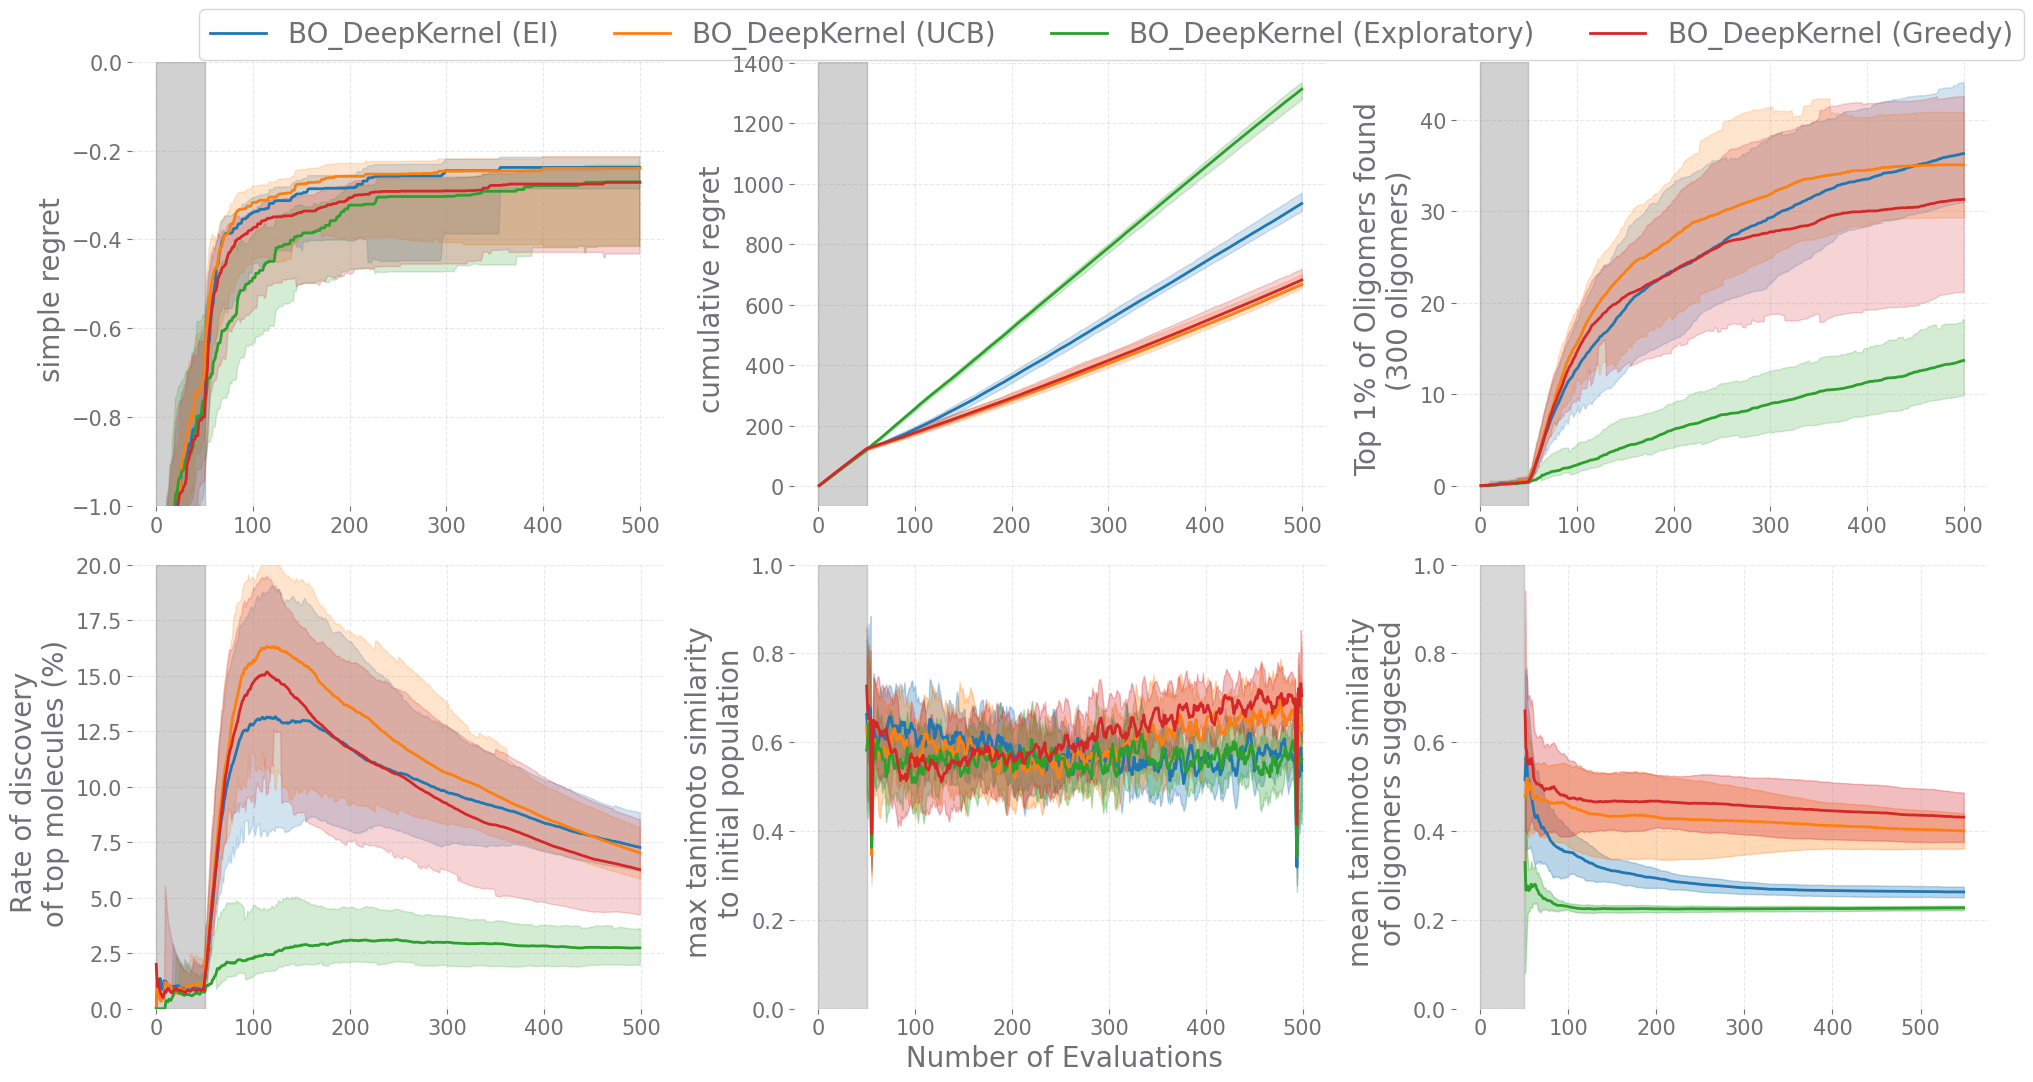

In [ ]:
importlib.reload(plot_results_all.tanimoto_similarity_utils)
df_mol_dict = plot_results_all.load_mol_dict()
%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot.iloc[[0, 2, 3, 4]]
legend_list = [
    "BO_DeepKernel (EI)",
    "BO_DeepKernel (UCB)",
    "BO_DeepKernel (Exploratory)",
    "BO_DeepKernel (Greedy)",
]  #'BO_DK','BO_DK new','SU EA','SU_EA New'


fig, axes, metric_dict_res = plot_results_all.plot_metric(
    df_plot,
    plot_function_list_single,
    results_dict,
    df_list,
    nb_iterations=min_num_iteration,
    number_cols=2,
)
df_mol_dict = plot_results_all.add_similarity_plots(
    axes,
    df_plot,
    df_mol_dict,
    results_dict,
    nb_iterations=min_num_iteration,
    nb_initialisation=50,
)
plot_results_all.save_mol_dict(df_mol_dict)
for ax_ in axes:
    ax_.set_xlabel("")

# update the axes geometry information
from matplotlib import gridspec

gs = gridspec.GridSpec(len(fig.axes), 3)
fig.set_size_inches(20, 30)
for i, ax in enumerate(fig.axes):
    ax.set_subplotspec(gs[i])
# set font size
for ax in fig.get_axes():
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
# hide legend
axes[0].legend().set_visible(False)
fig.tight_layout()
lg = axes[0].legend(
    loc="upper left", bbox_to_anchor=(0.1, 1.15), ncol=6, fontsize=20
)
for i in range(len(legend_list)):
    lg.texts[i].set_text(legend_list[i])

axes[0].set_ylim(-1, 0)
axes[3].set_ylim(0, 20)
# rename x ticks
axes[4].axvspan(0, 50, alpha=0.3, color="grey")
axes[5].axvspan(0, 50, alpha=0.3, color="grey")
axes[4].set_ylabel("max tanimoto similarity \n to initial population")
axes[4].set_xlabel(" Number of Evaluations", fontsize=20)
axes[2].set_ylabel("Top 1% of Oligomers found \n (300 oligomers)")
fig_name = "benchmarking_diff_acquisition function"
os.makedirs(save_folder, exist_ok=True)
pickle.dump(fig, open(save_folder + f"/{fig_name}.pkl", "wb"))


In [ ]:
importlib.reload(plot_results_all.tanimoto_similarity_utils)
df_mol_dict = plot_results_all.load_mol_dict()
%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot.iloc[[0, 5, 6, 10, 11, 12]]
legend_list = [
    "BO_DeepKernel",
    "BO_HotEnc(mord)",
    "BO_HotEnc(prop)",
    "SUEA",
    "EA",
    "Rand",
]  #'BO_DK','BO_DK new','SU EA','SU_EA New'


fig, axes, metric_dict_res = plot_results_all.plot_metric(
    df_plot,
    plot_function_list_single,
    results_dict,
    df_list,
    nb_iterations=min_num_iteration,
    number_cols=2,
)
df_mol_dict = plot_results_all.add_similarity_plots(
    axes,
    df_plot,
    df_mol_dict,
    results_dict,
    nb_iterations=min_num_iteration,
    nb_initialisation=50,
)
plot_results_all.save_mol_dict(df_mol_dict)
for ax_ in axes:
    ax_.set_xlabel("")

# update the axes geometry information
from matplotlib import gridspec

gs = gridspec.GridSpec(len(fig.axes), 2)
fig.set_size_inches(20, 30)
for i, ax in enumerate(fig.axes):
    ax.set_subplotspec(gs[i])
# set font size
for ax in fig.get_axes():
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
# hide legend
axes[0].legend().set_visible(False)
fig.tight_layout()
lg = axes[0].legend(
    loc="upper left", bbox_to_anchor=(0.1, 1.15), ncol=6, fontsize=20
)
for i in range(len(legend_list)):
    lg.texts[i].set_text(legend_list[i])

axes[0].set_ylim(-1, 0)
axes[3].set_ylim(0, 20)
# rename x ticks
axes[4].axvspan(0, 50, alpha=0.3, color="grey")
axes[5].axvspan(0, 50, alpha=0.3, color="grey")
axes[4].set_ylabel("max tanimoto similarity \n to initial population")
axes[4].set_xlabel(" Number of Evaluations", fontsize=20)
axes[2].set_ylabel("Top 1% of Oligomers found \n (300 oligomers)")
axes[5].set_xlabel(" Number of Evaluations", fontsize=20)
fig_name = "benchmarking_all_search_alg"
os.makedirs(save_folder, exist_ok=True)
pickle.dump(fig, open(save_folder + f"/{fig_name}.pkl", "wb"))


 keys : 0     BO_learned_new*selected*EI*/rds/general/user/m...
5     BO_precursor*all*EI**data/output/Full_dataset/...
6     BO_precursor*selected*EI**data/output/Full_dat...
10    ea_surrogate_new*selected*EI*/rds/general/user...
11    evolution_algorithm*selected*EI**data/output/F...
12    random*selected*EI**data/output/Full_dataset/3...
Name: key, dtype: object


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


len of mol_dataset 60697


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


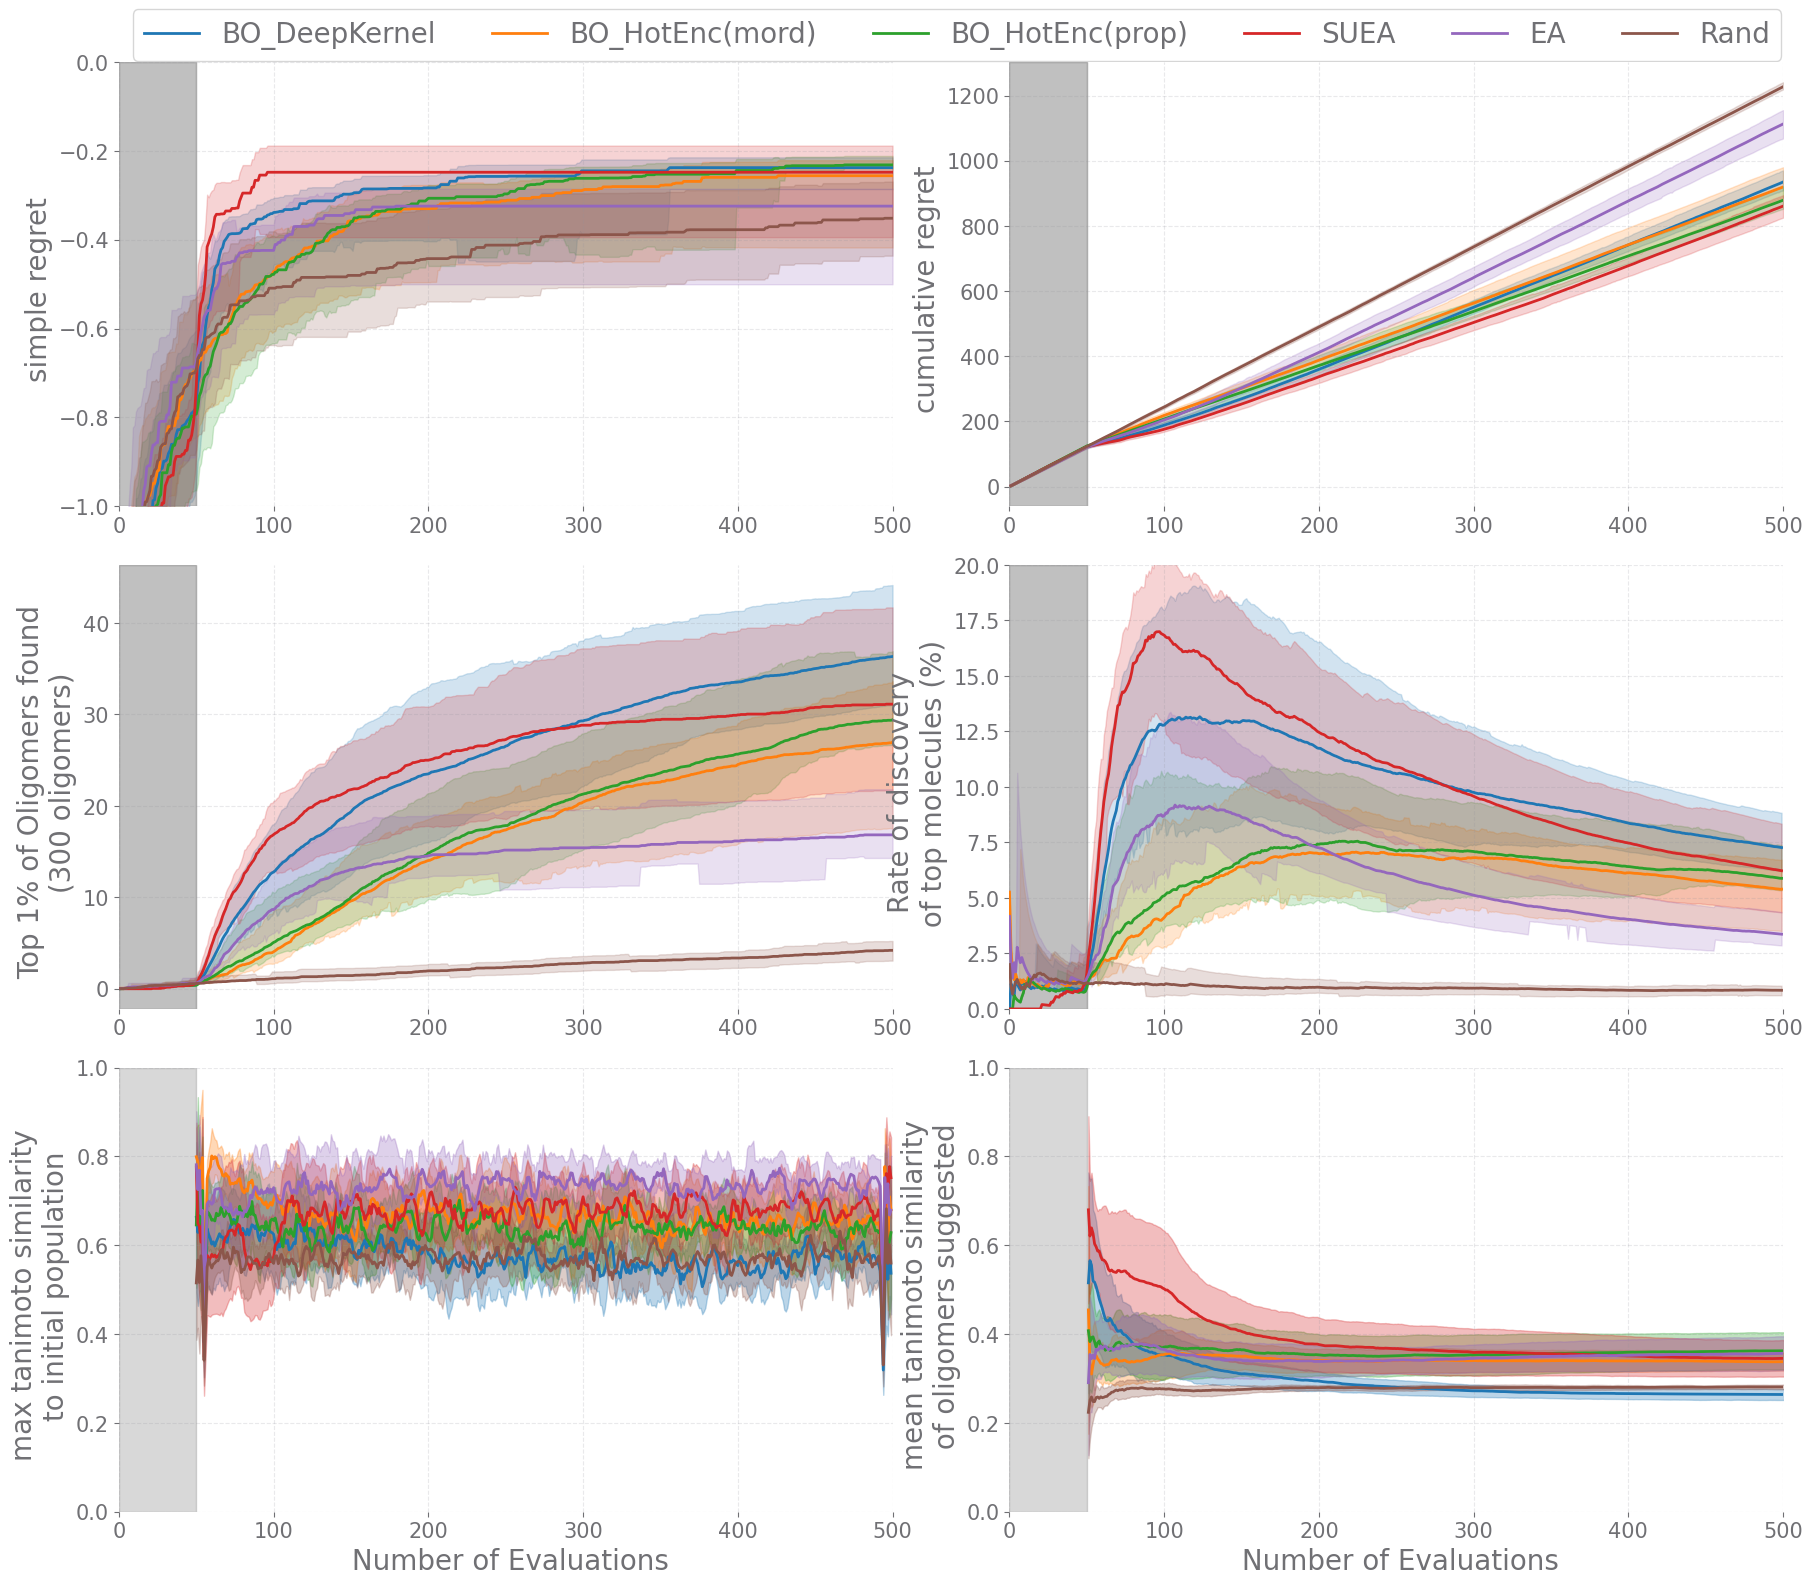

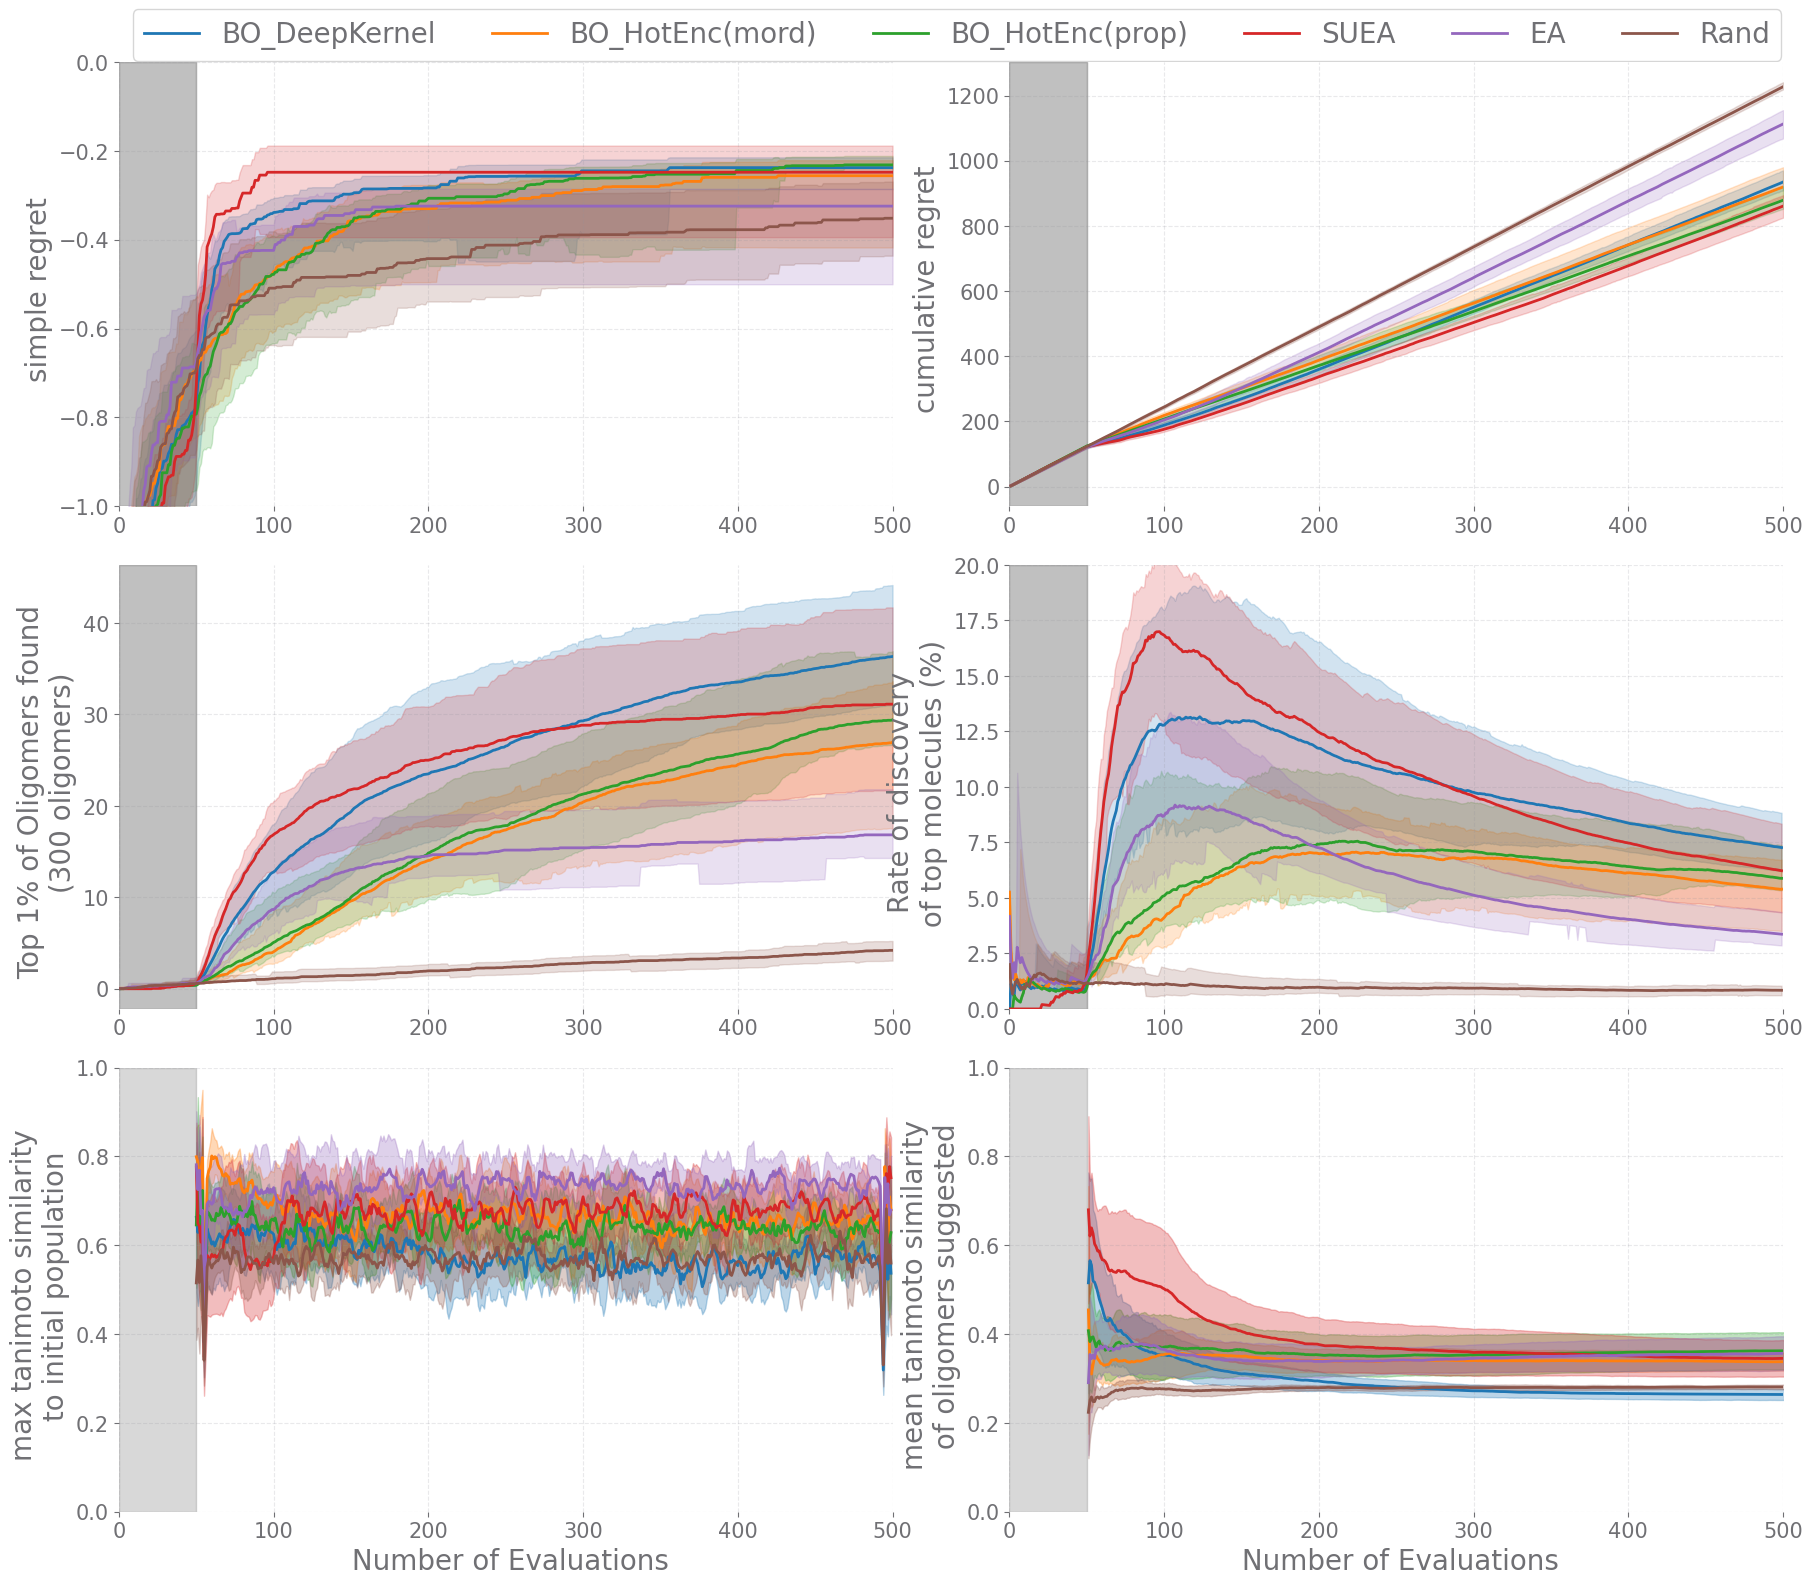

In [ ]:
# update the axes geometry information
fig_name = "benchmarking_all_search_alg"
fig = pickle.load(open(save_folder + f"/{fig_name}.pkl", "rb"))
from matplotlib import gridspec

gs = gridspec.GridSpec(len(fig.axes), 2)
fig.set_size_inches(18, 30)
for i, ax in enumerate(fig.axes):
    ax.set_subplotspec(gs[i])
# set font size
for ax in fig.get_axes():
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
# hide legend
axes[0].legend().set_visible(False)
# fig.tight_layout()
lg = fig.axes[0].legend(
    loc="upper left", bbox_to_anchor=(0, 1.15), ncol=6, fontsize=20
)
for i in range(len(legend_list)):
    lg.texts[i].set_text(legend_list[i])

axes[0].set_ylim(-1, 0)
axes[3].set_ylim(0, 20)
# rename x ticks
axes[4].axvspan(0, 50, alpha=0.3, color="grey")
axes[5].axvspan(0, 50, alpha=0.3, color="grey")
axes[4].set_ylabel("max tanimoto similarity \n to initial population")
axes[4].set_xlabel(" Number of Evaluations", fontsize=20)
fig.axes[2].set_ylabel("Top 1% of Oligomers found \n (300 oligomers)")
for ax in fig.axes:
    ax.set_xlim(0, 500)
fig.axes[5].set_xlabel(" Number of Evaluations", fontsize=20)

# fig_name = 'benchmarking_all_search_alg'
# os.makedirs(save_folder,exist_ok=True)
# pickle.dump(fig, open(save_folder+f'/{fig_name}.pkl','wb'))
fig

In [ ]:
importlib.reload(plot_results_all)
df_mol_dict = plot_results_all.load_mol_dict()
%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot  # .iloc[[0,1,2,3,4,5,6]]
legend_list = [
    "BO_DK",
    "BO_hot enc(mord)",
    "BO_hot enc (prop)",
    "SU EA",
    "EA",
    "Rand",
]


fig, axes, metric_dict_res = plot_results_all.plot_metric(
    df_plot,
    plot_function_list_multi,
    results_dict,
    df_list,
    nb_iterations=min_num_iteration,
    num_results_min=20,
)
axes[0].legend().set_visible(False)
fig.tight_layout()

axes[0].set_ylim(-1, 1)
# delete axes in the second row
for _ax in axes[3:]:
    _ax.set_visible(False)
from matplotlib import gridspec

gs = gridspec.GridSpec(len(fig.axes), 3)
fig.set_size_inches(20, 15)
lg = axes[0].legend(
    loc="upper left", bbox_to_anchor=(0.1, 1.15), ncol=6, fontsize=20
)
for i in range(len(legend_list)):
    lg.texts[i].set_text(legend_list[i])

 keys : 0     BO_learned_new*selected*EI*/rds/general/user/m...
1     BO_learned_new*selected*EI*/rds/general/user/m...
2     BO_learned_new*selected*UCB*/rds/general/user/...
3     BO_learned_new*selected*max_sigma*/rds/general...
4     BO_learned_new*selected*max_y_hat*/rds/general...
5     BO_precursor*all*EI**data/output/Full_dataset/...
6     BO_precursor*selected*EI**data/output/Full_dat...
7     BayesianOptimisation_ErrPred*all*EI_GNN*/rds/g...
8     BayesianOptimisation_ErrPred*all*UCB_GNN*/rds/...
9     ea_surrogate_new*selected*EI*/rds/general/user...
10    ea_surrogate_new*selected*EI*/rds/general/user...
11    evolution_algorithm*selected*EI**data/output/F...
12    random*selected*EI**data/output/Full_dataset/3...
Name: key, dtype: object
min_target is  -0.3176077110680689
min_target is  -0.3176077110680689
min_target is  -0.3176077110680689
min_target is  -0.3176077110680689
min_target is  -0.3176077110680689
min_target is  -0.3176077110680689
min_target is  -0.31760771106

30


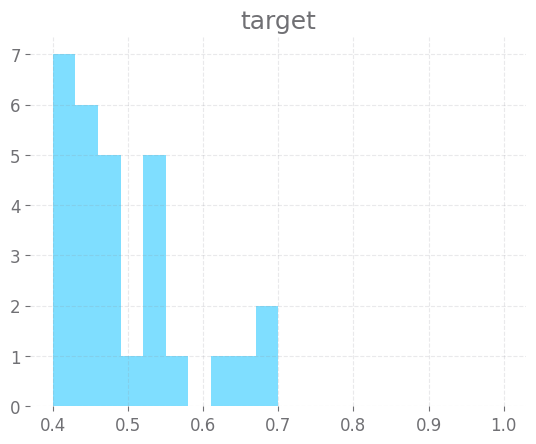

In [ ]:
%matplotlib inline
df_Benchmark.hist(target, bins=20, alpha=0.5, range=(0.4, 1))
print(
    df_Benchmark[
        df_Benchmark[target] > df_Benchmark[target].max() - 0.3
    ].shape[0]
)

 keys : 0     BO_learned_new*selected*EI*/rds/general/user/m...
5     BO_precursor*all*EI**data/output/Full_dataset/...
6     BO_precursor*selected*EI**data/output/Full_dat...
10    ea_surrogate_new*selected*EI*/rds/general/user...
11    evolution_algorithm*selected*EI**data/output/F...
12    random*selected*EI**data/output/Full_dataset/3...
Name: key, dtype: object
 number of new calculations 4037  number of new oligomers in top  117  for key  BO_learned_new*selected*EI*/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516//SchNet/splitrand-nummol20000/*data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/precursor_data_200324.pkl
 number of new calculations 5389  number of new oligomers in top  98  for key  BO_precursor*all*EI**data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/df_PCA_mordred_descriptor_290224.pkl
 number of new calculations 4079  number of new oligomers in top  100  

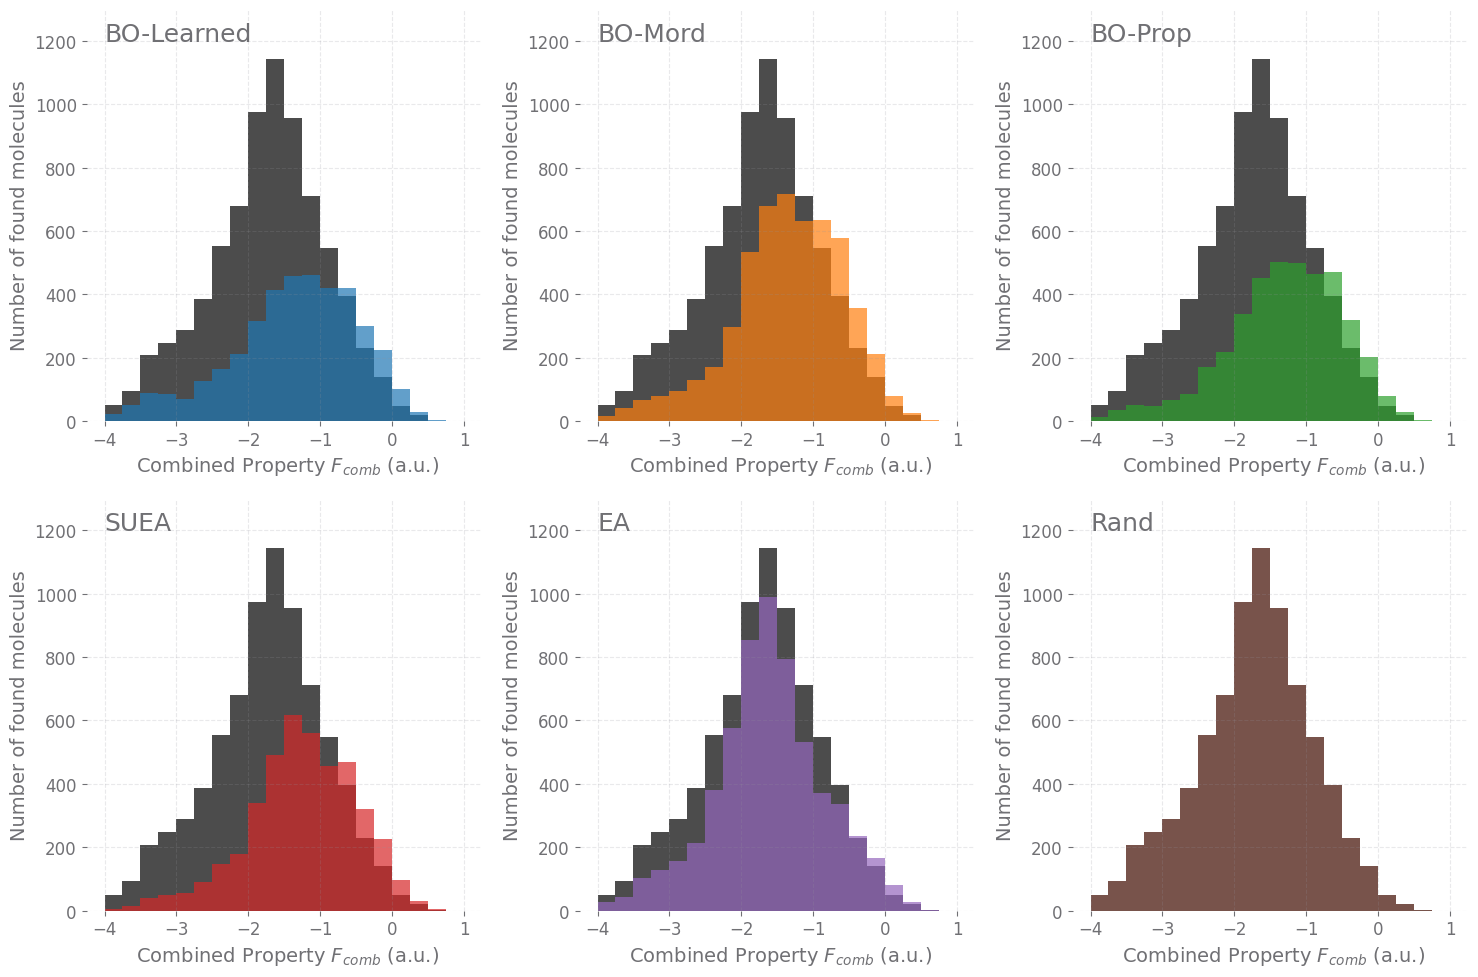

In [ ]:
# df_mol_dict = plot_results_all.load_mol_dict()
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot.iloc[[0, 5, 6, 10, 11, 12]]
# legend_list = ['BO_DK','BO_hot enc(mord)','BO_hot enc (prop)','SU EA','EA','Rand']
df_plot = df_plot.iloc[[0, 1, 2, 3, 4, 5]]
legend_list = [
    "BO-Learned",
    "BO-Mord",
    "BO-Prop",
    "SUEA",
    "EA",
    "Rand",
]  #'BO_DK','BO_DK new','SU EA','SU_EA New'
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax = ax.flatten()
color_list = sns.color_palette("tab10", len(df_plot))
df_plot["color"] = color_list
df_max_found_dict = {}
# df_results_dict = {}
keys = df_plot["key"]
print(" keys :", keys)
min_target = df_Benchmark[target].iloc[int(df_Benchmark.shape[0] * 0.01)]
range_res = (-4, 1)


for i, key in enumerate(keys.values):
    res = results_dict[key]
    color = df_plot[df_plot["key"] == key]["color"].iloc[0]

    metric_dict = {}

    df_results, df_max_found = Search_results_plot.get_df_max_target_found(
        res[:20],
        max_iteration=500,
        df_total=df_Benchmark,
        num_initialisation=50,
        target_name=target,
        min_target=min_target,
    )

    # df_max_found = df_max_found[~df_max_found['InChIKey'].isin(df_total_old['InChIKey'])]
    # df_Benchmark.hist(target,bins=20,ax=ax[i],color='black',alpha=0.5,range=range_res)

    df_results_dict[rand_key].hist(
        target,
        bins=20,
        ax=ax[i],
        label=key,
        color="black",
        alpha=0.7,
        range=range_res,
    )

    df_results.hist(
        target,
        bins=20,
        ax=ax[i],
        label=key,
        color=color,
        alpha=0.7,
        range=range_res,
    )

    df_max_found_dict[key] = df_max_found
    df_results_dict[key] = df_results
    print(
        " number of new calculations",
        df_results.shape[0],
        " number of new oligomers in top ",
        df_max_found.shape[0],
        " for key ",
        key,
    )
    # print('rate of discovery', df_max_found.shape[0]/df_results.shape[0])
    rand_key = "random*selected*EI**data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/precursor_data_200324.pkl"
    ax[i].set_ylabel("Number of found molecules")
    ax[i].set_xlabel(" Combined Property $F_{comb}$ (a.u.)")

    ax[i].set_title("")
    ax[i].set_ylim(0, 1300)
    # ax[i].set_xlim(0.4,1)

fig.tight_layout()
for i in range(len(legend_list)):
    ax[i].text(-4, 1200, legend_list[i], fontsize=18)

fig_name = "hist_toatl_benchmark"
os.makedirs(save_folder, exist_ok=True)
pickle.dump(fig, open(save_folder + f"/{fig_name}.pkl", "wb"))

 keys : 0     BO_learned_new*selected*EI*/rds/general/user/m...
5     BO_precursor*all*EI**data/output/Full_dataset/...
6     BO_precursor*selected*EI**data/output/Full_dat...
10    ea_surrogate_new*selected*EI*/rds/general/user...
11    evolution_algorithm*selected*EI**data/output/F...
12    random*selected*EI**data/output/Full_dataset/3...
Name: key, dtype: object
 number of new calculations 4037  number of new oligomers in top  117  for key  BO_learned_new*selected*EI*/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516//SchNet/splitrand-nummol20000/*data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/precursor_data_200324.pkl
 number of new calculations 5389  number of new oligomers in top  98  for key  BO_precursor*all*EI**data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/df_PCA_mordred_descriptor_290224.pkl
 number of new calculations 4079  number of new oligomers in top  100  

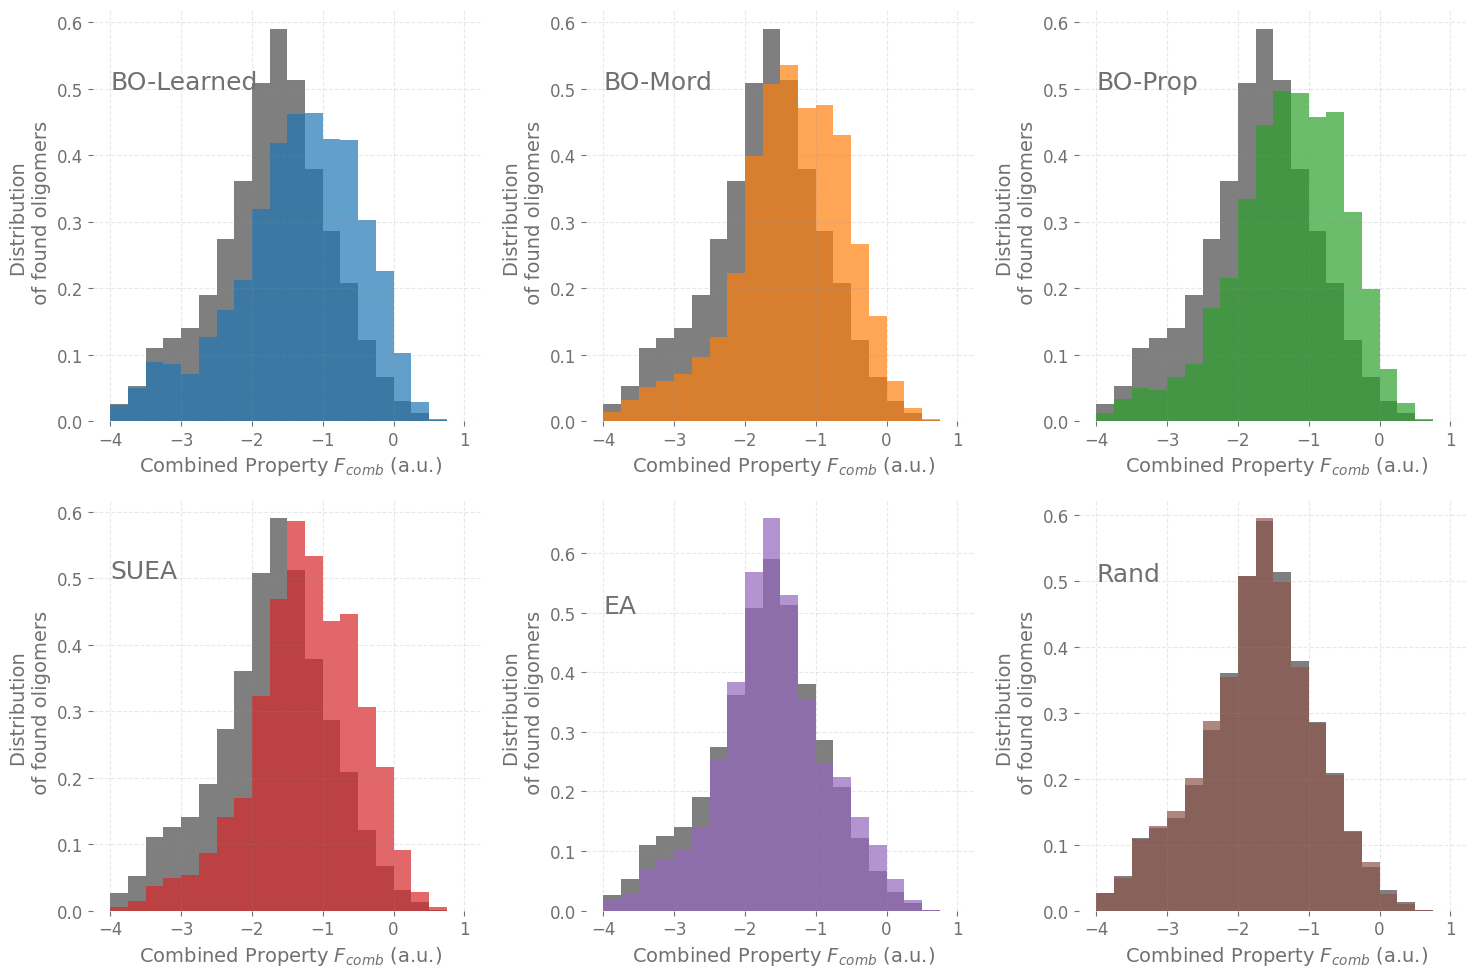

In [ ]:
# df_mol_dict = plot_results_all.load_mol_dict()
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot.iloc[[0, 5, 6, 10, 11, 12]]
# legend_list = ['BO_DK','BO_hot enc(mord)','BO_hot enc (prop)','SU EA','EA','Rand']
df_plot = df_plot.iloc[[0, 1, 2, 3, 4, 5]]
legend_list = [
    "BO-Learned",
    "BO-Mord",
    "BO-Prop",
    "SUEA",
    "EA",
    "Rand",
]  #'BO_DK','BO_DK new','SU EA','SU_EA New'
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax = ax.flatten()
color_list = sns.color_palette("tab10", len(df_plot))
df_plot["color"] = color_list
df_max_found_dict = {}
# df_results_dict = {}
keys = df_plot["key"]
print(" keys :", keys)
min_target = df_Benchmark[target].iloc[int(df_Benchmark.shape[0] * 0.01)]
range_res = (-4, 1)


for i, key in enumerate(keys.values):
    res = results_dict[key]
    color = df_plot[df_plot["key"] == key]["color"].iloc[0]

    metric_dict = {}

    df_results, df_max_found = Search_results_plot.get_df_max_target_found(
        res[:20],
        max_iteration=500,
        df_total=df_Benchmark,
        num_initialisation=50,
        target_name=target,
        min_target=min_target,
    )

    # df_max_found = df_max_found[~df_max_found['InChIKey'].isin(df_total_old['InChIKey'])]
    df_Benchmark.hist(
        target,
        bins=20,
        ax=ax[i],
        color="black",
        alpha=0.5,
        range=range_res,
        density=True,
    )

    # df_results_dict[rand_key] .hist(target,bins=20,ax=ax[i],label=key,color='black',alpha=0.7,range=range_res,density=True)

    df_results.hist(
        target,
        bins=20,
        ax=ax[i],
        label=key,
        color=color,
        alpha=0.7,
        range=range_res,
        density=True,
    )

    # d#f_max_found.hist(target_name,bins=50,ax=ax[1],label=key,color=color,alpha=0.7,range=range_max,density=False)
    df_max_found_dict[key] = df_max_found
    df_results_dict[key] = df_results
    print(
        " number of new calculations",
        df_results.shape[0],
        " number of new oligomers in top ",
        df_max_found.shape[0],
        " for key ",
        key,
    )
    # print('rate of discovery', df_max_found.shape[0]/df_results.shape[0])
    rand_key = "random*selected*EI**data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/precursor_data_200324.pkl"
    ax[i].set_ylabel("Distribution \n of found oligomers")
    ax[i].set_xlabel(" Combined Property $F_{comb}$ (a.u.)")

    ax[i].set_title("")
    # ax[i].set_ylim(0,1300)
    # ax[i].set_xlim(0.4,1)

fig.tight_layout()
for i in range(len(legend_list)):
    ax[i].text(-4, 0.5, legend_list[i], fontsize=18)

fig_name = "hist_toatl_benchmark"
os.makedirs(save_folder, exist_ok=True)
pickle.dump(fig, open(save_folder + f"/{fig_name}.pkl", "wb"))